In [1]:
import numpy as np # linear algebra
import datatable as dt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt # for visualization 
import seaborn as sns
import plotly.graph_objects as go # can resize graphs
import plotly.express as px # for graphing volumes traded
import gc # to collect garbage
import traceback
import gresearch_crypto # required to use their API

import pandas_datareader as web # Getting web data

import datetime
import time

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, RobustScaler
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from numpy import nan
import math # to use sqrt function
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/g-research-crypto-forecasting/example_sample_submission.csv
/kaggle/input/g-research-crypto-forecasting/asset_details.csv
/kaggle/input/g-research-crypto-forecasting/example_test.csv
/kaggle/input/g-research-crypto-forecasting/train.csv
/kaggle/input/g-research-crypto-forecasting/supplemental_train.csv
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/__init__.py


In [2]:
# Set graph style and font
# sns.set()
# Change the axes' title and label size to 18 & 16 by default and default figure size, and make title bold
# Axes formatter limit will only display scientific notation if it's > 10^7 (or 10 million JPY) or < 10^-5
# plt.rcParams.update({'axes.titleweight': 'bold','figure.figsize': (16,10),'axes.titlesize': 18,'axes.labelsize': 16, 
#                      'legend.fontsize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'font.family': 'serif', 
#                      'axes.formatter.limits':'-5, 7'}) 

# Loading in data

In [3]:
# For Kaggle only
path = '/kaggle/input/g-research-crypto-forecasting/'
orig_df_train = pd.read_csv(path + 'train.csv')
supp_df_train = pd.read_csv(path + 'supplemental_train.csv')

## Merging main data with supplemental data together

In [4]:
# The right join is outer as I'm stacking supplemental data on top of main data
merged_df = orig_df_train.merge(supp_df_train, how = 'outer')
# merged_df

In [5]:
# Delete unused variables to save some memory
# del orig_df_train, supp_df_train

In [6]:
# Reduce size by converting to float
merged_df[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', \
           'Target']] = merged_df[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']].astype(np.float32)
print(merged_df.shape)

# Fill in missing 'target' values with 0
# merged_df['Target'] = merged_df['Target'].fillna(0) # Fill in missing values

# Drop any rows with missing values
merged_df = merged_df.dropna(how = 'any')
print(merged_df.shape)

# Convert UNIX timestamp to human time
merged_df['date'] = pd.to_datetime(merged_df['timestamp'],unit='s')

(26473300, 10)
(25720891, 10)


Fill in the target column with 0 if nan.

In [7]:
# Assign human time as index
merged_df.set_index('date', inplace = True)
# merged_df.describe(include = 'all')

In [8]:
# Group data by the hour to reduce the rows
hourly_df = merged_df.groupby('Asset_ID').resample('H').mean()
hourly_df['date'] = pd.to_datetime(hourly_df['timestamp'],unit='s')
hourly_df = hourly_df.sort_index()
# hourly_df.sort_values('date', axis = 0)
hourly_df

timestamp  Asset_ID       Count      Open  \
Asset_ID date                                                                
0        2018-01-01 00:00:00  1.514767e+09       0.0   19.813559  8.380515   
         2018-01-01 01:00:00  1.514770e+09       0.0   12.178572  8.318839   
         2018-01-01 02:00:00  1.514774e+09       0.0   11.654546  8.280453   
         2018-01-01 03:00:00  1.514777e+09       0.0   11.683333  8.363050   
         2018-01-01 04:00:00  1.514781e+09       0.0   10.333333  8.413568   
...                                    ...       ...         ...       ...   
13       2022-01-09 19:00:00  1.641757e+09      13.0  302.583344  0.066831   
         2022-01-09 20:00:00  1.641760e+09      13.0  198.850006  0.066976   
         2022-01-09 21:00:00  1.641764e+09      13.0  151.283340  0.066681   
         2022-01-09 22:00:00  1.641767e+09      13.0  115.533333  0.066594   
         2022-01-09 23:00:00  1.641771e+09      13.0  185.022217  0.066176   

                                  High       Low     Close        Volume  \
Asset_ID date                                                              
0        2018-01-01 00:00:00  8.391117  8.359434  8.368543  8.354858e+02   
         2018-01-01 01:00:00  8.327828  8.303082  8.318329  3.835764e+02   
         2018-01-01 02:00:00  8.291567  8.269445  8.280216  5.106060e+02   
         2018-01-01 03:00:00  8.370503  8.354392  8.364997  5.488528e+02   
         2018-01-01 04:00:00  8.422960  8.403096  8.414389  2.433758e+02   
...                                ...       ...       ...           ...   
13       2022-01-09 19:00:00  0.066889  0.066785  0.066843  4.072674e+06   
         2022-01-09 20:00:00  0.067015  0.066927  0.066970  1.774328e+06   
         2022-01-09 21:00:00  0.066719  0.066638  0.066678  9.386550e+05   
         2022-01-09 22:00:00  0.066625  0.066561  0.066593  6.955632e+05   
         2022-01-09 23:00:00  0.066226  0.066135  0.066175  9.340274e+05   

                                  VWAP    Target                          date  
Asset_ID date                                                                   
0        2018-01-01 00:00:00  8.370252 -0.003394 2018-01-01 00:30:00.000000000  
         2018-01-01 01:00:00  8.313540 -0.000295 2018-01-01 01:30:00.000000000  
         2018-01-01 02:00:00  8.279114 -0.000115 2018-01-01 02:29:40.363636224  
         2018-01-01 03:00:00  8.360475  0.002232 2018-01-01 03:29:30.000000000  
         2018-01-01 04:00:00  8.415125  0.004297 2018-01-01 04:29:30.000000000  
...                                ...       ...                           ...  
13       2022-01-09 19:00:00  0.066838  0.000190 2022-01-09 19:29:30.000000000  
         2022-01-09 20:00:00  0.066970 -0.000598 2022-01-09 20:29:30.000000000  
         2022-01-09 21:00:00  0.066679 -0.000344 2022-01-09 21:29:30.000000000  
         2022-01-09 22:00:00  0.066593  0.000221 2022-01-09 22:29:30.000000000  
         2022-01-09 23:00:00  0.066178  0.000145 2022-01-09 23:22:00.000000000  

[469633 rows x 11 columns]

In [9]:
hourly_df.index

MultiIndex([( 0, '2018-01-01 00:00:00'),
            ( 0, '2018-01-01 01:00:00'),
            ( 0, '2018-01-01 02:00:00'),
            ( 0, '2018-01-01 03:00:00'),
            ( 0, '2018-01-01 04:00:00'),
            ( 0, '2018-01-01 05:00:00'),
            ( 0, '2018-01-01 06:00:00'),
            ( 0, '2018-01-01 07:00:00'),
            ( 0, '2018-01-01 08:00:00'),
            ( 0, '2018-01-01 09:00:00'),
            ...
            (13, '2022-01-09 14:00:00'),
            (13, '2022-01-09 15:00:00'),
            (13, '2022-01-09 16:00:00'),
            (13, '2022-01-09 17:00:00'),
            (13, '2022-01-09 18:00:00'),
            (13, '2022-01-09 19:00:00'),
            (13, '2022-01-09 20:00:00'),
            (13, '2022-01-09 21:00:00'),
            (13, '2022-01-09 22:00:00'),
            (13, '2022-01-09 23:00:00')],
           names=['Asset_ID', 'date'], length=469633)

In [10]:
asset_details = pd.read_csv(path + 'asset_details.csv')
# Add the asset symbols
asset_details['Symbol'] = ['BCH', 'BNB', 'BTC', 'EOS', 'ETC', 'ETH', 'LTC', 'XMR', 'TRX', 'XLM', 'ADA', 'MIOTA', 'MKR', 'DOGE']

# Sort value from smallest to highest
asset_details.sort_values('Asset_ID', inplace = True)
asset_weight_dict = {asset_details['Asset_ID'].tolist()[idx]: asset_details['Weight'].tolist()[idx] for idx in range(len(asset_details))}
asset_name_dict = {asset_details['Asset_ID'].tolist()[idx]: asset_details['Asset_Name'].tolist()[idx] for idx in range(len(asset_details))}
asset_details

,Asset_ID,Weight,Asset_Name,Symbol
1,0,4.304065,Binance Coin,BNB
2,1,6.779922,Bitcoin,BTC
0,2,2.397895,Bitcoin Cash,BCH
10,3,4.406719,Cardano,ADA
13,4,3.555348,Dogecoin,DOGE
3,5,1.386294,EOS.IO,EOS
5,6,5.894403,Ethereum,ETH
4,7,2.079442,Ethereum Classic,ETC
11,8,1.098612,IOTA,MIOTA
6,9,2.397895,Litecoin,LTC


# Dividing each asset into its own dataframe

In [11]:
# Create 2 data frame dictionaries to store all the data frames by the minutes and hours
minutes = {coin : pd.DataFrame for coin in asset_details['Asset_ID']} # by the minute
hourly = {hourly_coin : pd.DataFrame for hourly_coin in asset_details['Asset_ID']}
# Extract data for each asset and set time as index
for ID, symbol in zip(asset_details['Asset_ID'], asset_details['Symbol']):
    minutes[symbol] = merged_df[:][merged_df['Asset_ID'] == ID]
    minutes[symbol]['date'] = pd.to_datetime(minutes[symbol]['timestamp'],unit='s') # Convert from Unix timestamp to human time
    minutes[symbol].set_index('date', inplace = True)  # Necessary in order to use resampling
    hourly[symbol] = minutes[symbol].resample('H').mean().replace(np.NaN, 0)
    hourly[symbol].reset_index(inplace = True) # Reset index in order to be able to sort
    hourly[symbol]['date'] = pd.to_datetime(hourly[symbol]['timestamp'],unit='s')
    hourly[symbol] = hourly[symbol].sort_index()
    minutes[symbol].reset_index(inplace = True) # Reset index in order to be able to sort and work with the training function

In [12]:
# Check to see if it's sorted correctly
hourly['BNB']

,date,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,2018-01-01 00:30:00.000000000,1.514767e+09,0.0,19.813559,8.380515,8.391117,8.359434,8.368543,835.485779,8.370252,-0.003394
1,2018-01-01 01:30:00.000000000,1.514770e+09,0.0,12.178572,8.318839,8.327828,8.303082,8.318329,383.576416,8.313540,-0.000295
2,2018-01-01 02:29:40.363636224,1.514774e+09,0.0,11.654546,8.280453,8.291567,8.269445,8.280216,510.606018,8.279114,-0.000115
3,2018-01-01 03:29:30.000000000,1.514777e+09,0.0,11.683333,8.363050,8.370503,8.354392,8.364997,548.852844,8.360475,0.002232
4,2018-01-01 04:29:30.000000000,1.514781e+09,0.0,10.333333,8.413568,8.422960,8.403096,8.414389,243.375839,8.415125,0.004297
...,...,...,...,...,...,...,...,...,...,...,...
35275,2022-01-09 19:29:30.000000000,1.641757e+09,0.0,298.049988,441.781799,442.146393,441.472382,441.840454,663.568787,441.821381,0.000029
35276,2022-01-09 20:29:30.000000000,1.641760e+09,0.0,222.699997,443.063354,443.289978,442.727844,443.032227,402.800537,443.013062,-0.000109
35277,2022-01-09 21:29:30.000000000,1.641764e+09,0.0,197.000000,442.293762,442.515015,442.035431,442.294678,329.644714,442.285645,0.000465
35278,2022-01-09 22:29:30.000000000,1.641767e+09,0.0,214.100006,441.628571,441.866119,441.338318,441.609406,298.200378,441.613922,-0.000027


In [13]:
# See the rows with NaN values
hourly['ADA'].isna().sum()

date         0
timestamp    0
Asset_ID     0
Count        0
Open         0
High         0
Low          0
Close        0
Volume       0
VWAP         0
Target       0
dtype: int64

In [14]:
minutes['BNB']

,date,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,2018-01-01 00:01:00,1514764860,0,5.0,8.530000,8.530000,8.530000,8.530000,78.379997,8.530000,-0.014399
1,2018-01-01 00:02:00,1514764920,0,7.0,8.530000,8.530000,8.514500,8.514500,71.389999,8.520215,-0.015875
2,2018-01-01 00:03:00,1514764980,0,45.0,8.506500,8.529900,8.484800,8.484800,1546.819946,8.501393,-0.015410
3,2018-01-01 00:04:00,1514765040,0,14.0,8.500900,8.506600,8.474400,8.500900,125.800003,8.479810,-0.012524
4,2018-01-01 00:05:00,1514765100,0,5.0,8.500700,8.500700,8.456000,8.456000,125.010002,8.458435,-0.005940
...,...,...,...,...,...,...,...,...,...,...,...
2088835,2022-01-09 23:40:00,1641771600,0,153.0,437.984680,438.437988,437.799988,438.299347,250.376694,438.179810,0.000096
2088836,2022-01-09 23:41:00,1641771660,0,249.0,438.368988,438.885986,438.200012,438.570679,1080.568237,438.589386,0.000252
2088837,2022-01-09 23:42:00,1641771720,0,125.0,438.522339,438.944000,438.399994,438.553345,290.040924,438.603027,0.000093
2088838,2022-01-09 23:43:00,1641771780,0,119.0,438.587677,438.863007,438.500000,438.760986,93.772644,438.676971,0.000965


# EDA

## Candlestick charts

In [15]:
# Function to draw candlestick charts
def candlestick_chart(data, title):
    candlestick = go.Figure(data = [go.Candlestick(x =data.index, 
                                               open = data[('Open')], 
                                               high = data[('High')], 
                                               low = data[('Low')], 
                                               close = data[('Close')])])
    candlestick.update_xaxes(title_text = 'Time',
                             rangeslider_visible = True)

    candlestick.update_layout(
    title = {
        'text': '{:} Candlestick Chart'.format(title),
        'y':0.90,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'} , 
    template="plotly_white")

    candlestick.update_yaxes(title_text = 'Price in USD', ticksuffix = '$')
    return candlestick

In [16]:
# Plot BTC price for last 1000 points
btc_hourly = candlestick_chart(hourly['BTC'][-1000:], 'BTC price over time')
btc_hourly.show()

## OHLC charts

In [17]:
def ohlc_chart(data,title):
    ohlc = go.Figure(data = [go.Ohlc(x =data.index, 
                                               open = data[('Open')], 
                                               high = data[('High')], 
                                               low = data[('Low')], 
                                               close = data[('Close')])])
    ohlc.update_xaxes(title_text = 'Time',
                             rangeslider_visible = True)

    ohlc.update_layout(
    title = {
        'text': '{:} OHLC Chart'.format(title),
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        template="plotly_white")

    ohlc.update_yaxes(title_text = 'Price in USD', ticksuffix = '$')
    return ohlc

In [18]:
# Chart for ETH for last 200 rows
# ohlc_chart(dfDict['ETH'][-200:], title = "Ethereum(ETH) price over last 200 minutes")

## Area plots (volumes traded)

In [19]:
def vol_traded(data ,title,color):
    area = px.area(data_frame=data,
               x = data.index ,
               y = "Volume",
               markers = True)
    area.update_traces(line_color=color)
    area.update_xaxes(
        title_text = 'Time',
        rangeslider_visible = True)
    area.update_yaxes(title_text = 'Number of trades every minute')
    area.update_layout(showlegend = True,
        title = {
            'text': '{:} Volume Traded'.format(title),
            'y':0.94,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        template="plotly_white")
    return area

In [20]:
# vol_traded(dfDict['ETH'][-50:], "Ethereum (ETH) volume over last 50 minutes", color = "Red")

# Preprocessing

# Variables to change

In [21]:
DEVICE = "GPU" #or "CPU"

SEED = 25

# CV PARAMS
FOLDS = 5
GROUP_GAP = 130
MAX_TEST_GROUP_SIZE = 180
MAX_TRAIN_GROUP_SIZE = 280

# LOAD STRICT? YES=1 NO=0 | see: https://www.kaggle.com/julian3833/proposal-for-a-meaningful-lb-strict-lgbm
LOAD_STRICT = True

# WHICH YEARS TO INCLUDE? YES=1 NO=0
INC2021 = 0
INC2020 = 0
INC2019 = 0
INC2018 = 0
INC2017 = 0
INCCOMP = 1
INCSUPP = 0

# HYPER PARAMETERS
LEARNING_RATE = [0.09, 0.09, 0.09, 0.09, 0.09]
N_ESTIMATORS = [1000, 1000, 1000, 1000, 1000]
MAX_DEPTH = [10, 10, 10, 10, 10]

# Feature engineering

In [22]:
# Two features from the competition tutorial
def upper_shadow(df): return df['High'] - np.maximum(df['Close'], df['Open'])
def lower_shadow(df): return np.minimum(df['Close'], df['Open']) - df['Low']

# A utility function to build features from the original df
def get_features(df):
    df_feat = df[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].copy()
    df_feat['upper_Shadow'] = upper_shadow(df_feat)
    df_feat['lower_Shadow'] = lower_shadow(df_feat)
    df_feat["high_div_low"] = df_feat["High"] / df_feat["Low"]
    df_feat["open_sub_close"] = df_feat["Open"] - df_feat["Close"]
    return df_feat

# Configure the model

## Competition metric

In [23]:
def corr(a, b, w):
    cov = lambda x, y: np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(y, weights=w))) / np.sum(w)
    return cov(a, b) / np.sqrt(cov(a, a) * cov(b, b))

# Catboost Version
def get_catb_metric(w):
    class WCorrMetric(object):
        def get_final_error(self, error, weight): return error 
        def is_max_optimal(self): return True
        def evaluate(self, approxes, target, weight):
            approx = approxes[0]
            weight_sum = 1.0
            error_sum = corr(target, approx, w)
            return error_sum, weight_sum

## The model

In [24]:
def build_model(fold, weight = 1.0):

    model = CatBoostRegressor(iterations = N_ESTIMATORS[fold], depth = MAX_DEPTH[fold], \
                              learning_rate = LEARNING_RATE[fold], task_type = "GPU" if DEVICE == 'GPU' else None, \
                              eval_metric = get_catb_metric(weight))
    return model

# Time Series CV

In [25]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]

                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size

            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]


            if self.verbose > 0:
                    pass

            yield [int(i) for i in train_array], [int(i) for i in test_array]

# Training

## See the CV visually

<AxesSubplot:title={'center':'PurgedGroupTimeSeriesSplit'}, xlabel='Sample index', ylabel='CV iteration'>

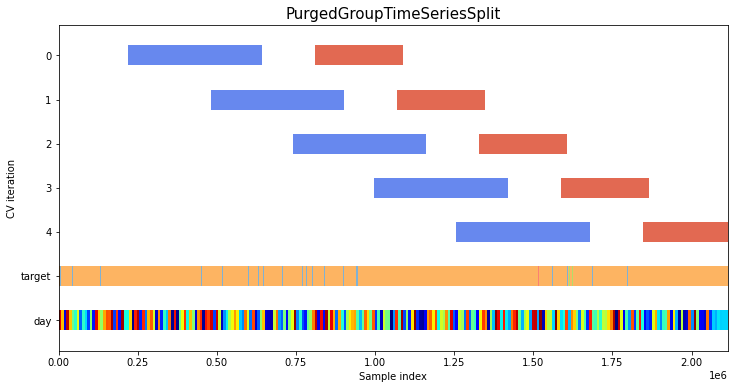

In [26]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    cmap_cv = plt.cm.coolwarm
    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))    
    for ii, (tr, tt) in enumerate(list(cv.split(X=X, y=y, groups=group))):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0        
        ax.scatter(range(len(indices)), [ii + .5] * len(indices), c=indices, marker='_', lw=lw, cmap=cmap_cv, vmin=-.2, vmax=1.2)
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker='_', lw=lw, cmap=plt.cm.Set3)
    ax.scatter(range(len(X)), [ii + 2.5] * len(X), c=group, marker='_', lw=lw, cmap=cmap_data)
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels, xlabel='Sample index', ylabel="CV iteration", ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

def plot_importance(importances, features_names, PLOT_TOP_N = 20, figsize=(12, 20)):
    try: plt.close()
    except: pass
    importance_df = pd.DataFrame(data=importances, columns=features_names)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    plt.title('Feature Importances')
    sns.boxplot(data=sorted_importance_df[plot_cols], orient='h', ax=ax)
    plt.show()
    
# asset_id = 0
# df = load_training_data_for_asset(asset_id) # not loading because I use my the original data 'merged_df' (too big)
# Using hourly_df, if this is still too big, I'll just use each asset df, e.g. hourly['BNB']
df = minutes['BTC']  # Change here to see different asset and timeline (minutes, hourly)
df_proc = get_features(df)
df_proc['date'] = df['date'].copy() 
df_proc['y'] = df['Target']
df_proc = df_proc.dropna(how="any")
X = df_proc.drop("y", axis=1)
y = df_proc["y"]
groups = pd.factorize(X['date'].dt.day.astype(str) + '_' + X['date'].dt.month.astype(str) + '_' + X['date'].dt.year.astype(str))[0]
X = X.drop(columns = 'date')

fig, ax = plt.subplots(figsize = (12, 6))
cv = PurgedGroupTimeSeriesSplit(n_splits = FOLDS, group_gap = GROUP_GAP, max_train_group_size=MAX_TRAIN_GROUP_SIZE, max_test_group_size=MAX_TEST_GROUP_SIZE)
plot_cv_indices(cv, X, y, groups, ax, FOLDS, lw=20)

## Main training function

Training model for BNB    (ID=0 )
#########################
#### FOLD 1
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 1 OOF MSE 0.000 | WCORR: -0.002
#########################
#### FOLD 2
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 2 OOF MSE 0.000 | WCORR: 0.015
#########################
#### FOLD 3
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 3 OOF MSE 0.000 | WCORR: 0.012
#########################
#### FOLD 4
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 4 OOF MSE 0.000 | WCORR: -0.005
#########################
#### FOLD 5
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 5 OOF MSE 0.000 | WCORR: -0.018


--------------------------------------------------------------------------------
Finished training Binance Coin. Results:
Model: r2_score: -0.0005474448650752972 | pearsonr: 0.0005259249059666867 | wcorr: 0.0005259249249576869

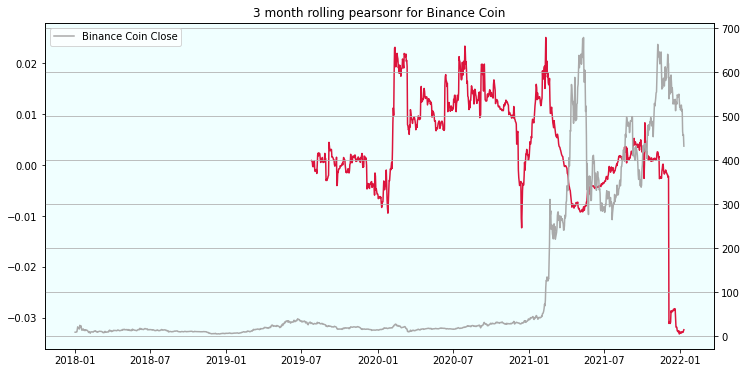

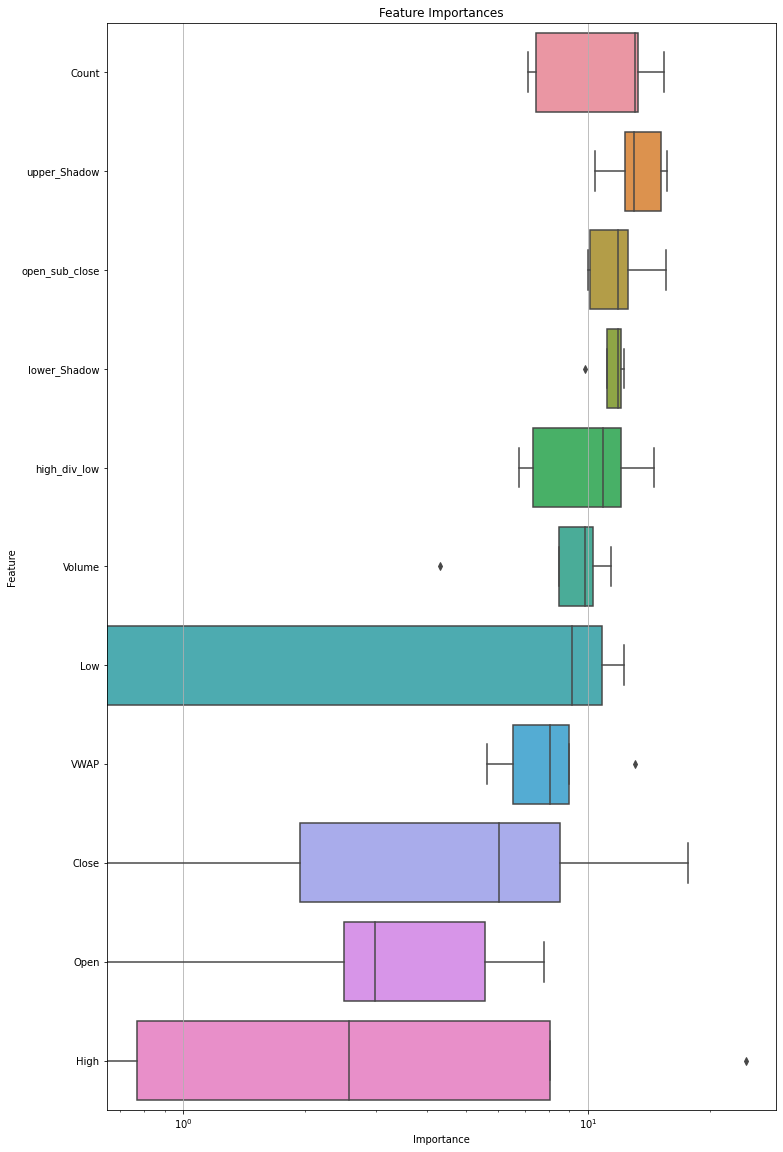

Training model for BTC    (ID=1 )
#########################
#### FOLD 1
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 1 OOF MSE 0.000 | WCORR: -0.002
#########################
#### FOLD 2
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 2 OOF MSE 0.000 | WCORR: 0.013
#########################
#### FOLD 3
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 3 OOF MSE 0.000 | WCORR: 0.020
#########################
#### FOLD 4
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 4 OOF MSE 0.000 | WCORR: -0.010
#########################
#### FOLD 5
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 5 OOF MSE 0.000 | WCORR: -0.009


--------------------------------------------------------------------------------
Finished training Bitcoin. Results:
Model: r2_score: -5.407666823931123e-05 | pearsonr: 0.005335562234866899 | wcorr: 0.00533556235618945 
Predic

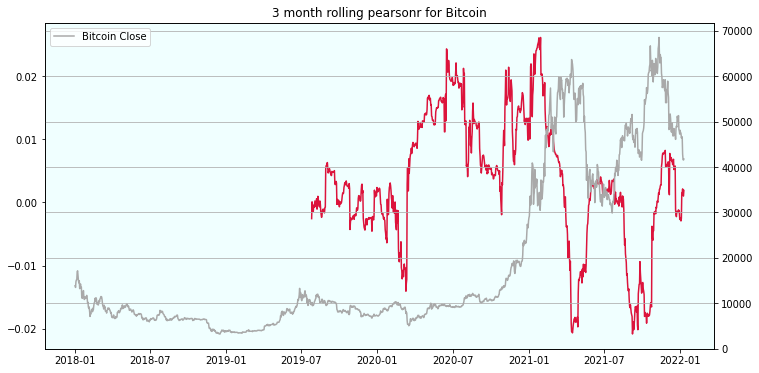

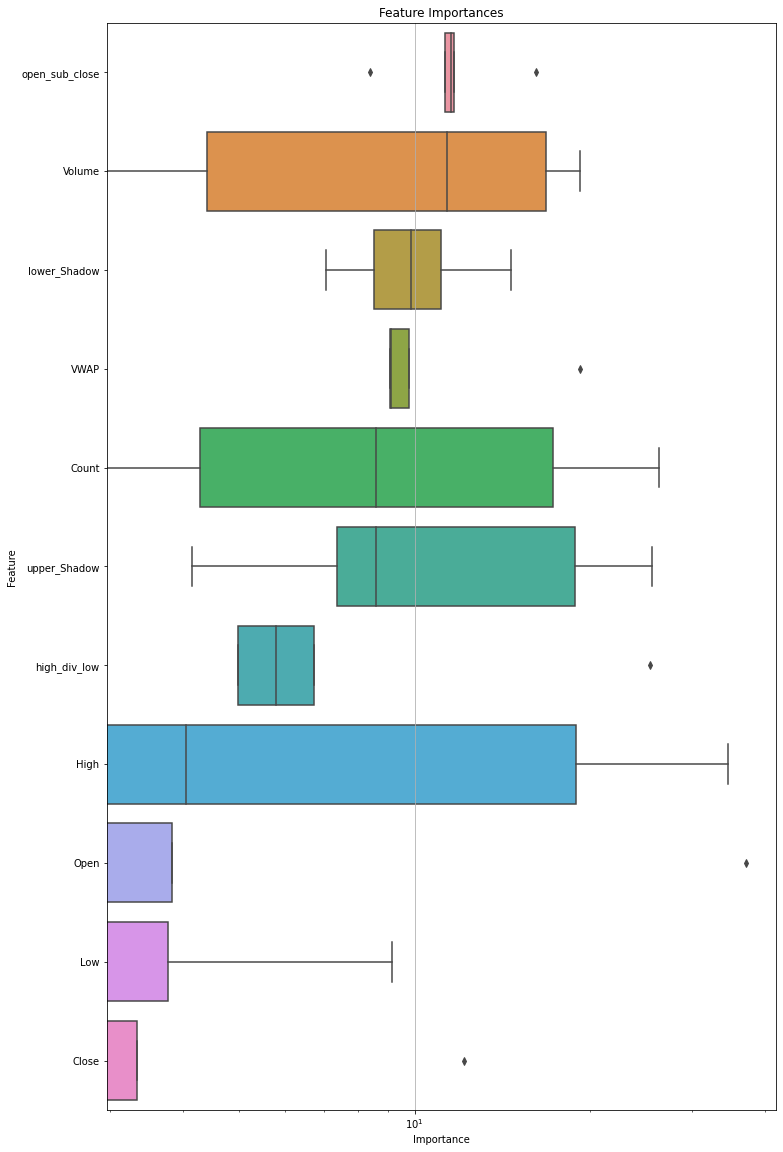

Training model for BCH    (ID=2 )
#########################
#### FOLD 1
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 1 OOF MSE 0.000 | WCORR: 0.003
#########################
#### FOLD 2
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 2 OOF MSE 0.000 | WCORR: -0.052
#########################
#### FOLD 3
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 3 OOF MSE 0.000 | WCORR: 0.015
#########################
#### FOLD 4
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 4 OOF MSE 0.000 | WCORR: 0.009
#########################
#### FOLD 5
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 5 OOF MSE 0.000 | WCORR: 0.005


--------------------------------------------------------------------------------
Finished training Bitcoin Cash. Results:
Model: r2_score: -0.00012338752041762824 | pearsonr: -0.0007495057494478082 | wcorr: -0.000749506011087540

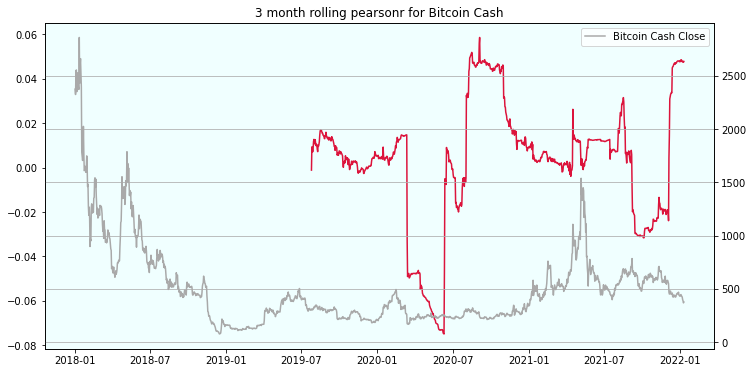

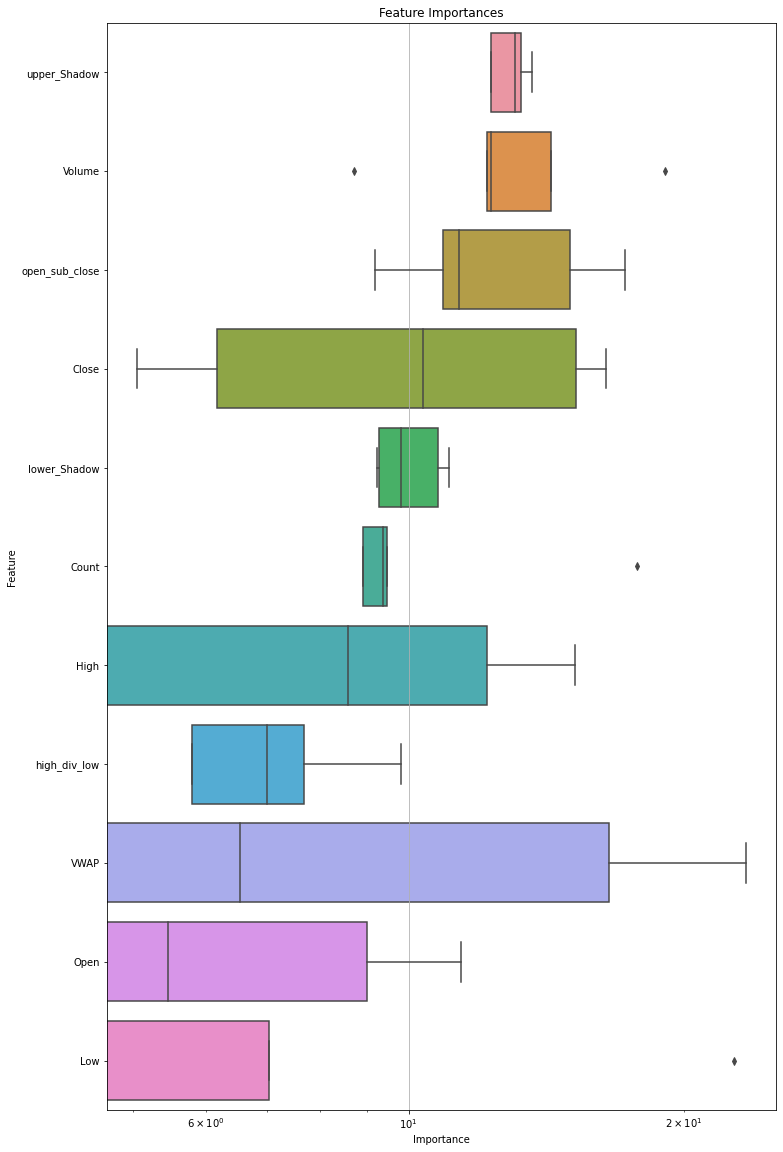

Training model for ADA    (ID=3 )
#########################
#### FOLD 1
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 1 OOF MSE 0.000 | WCORR: 0.019
#########################
#### FOLD 2
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 2 OOF MSE 0.000 | WCORR: 0.006
#########################
#### FOLD 3
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 3 OOF MSE 0.000 | WCORR: 0.009
#########################
#### FOLD 4
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 4 OOF MSE 0.000 | WCORR: 0.020
#########################
#### FOLD 5
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 5 OOF MSE 0.000 | WCORR: 0.015


--------------------------------------------------------------------------------
Finished training Cardano. Results:
Model: r2_score: -3.5178042379069296e-06 | pearsonr: 0.011483702045816785 | wcorr: 0.011483701218723118 
Predict

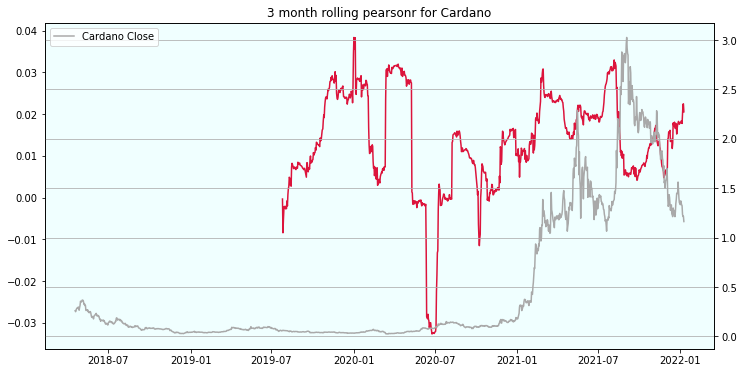

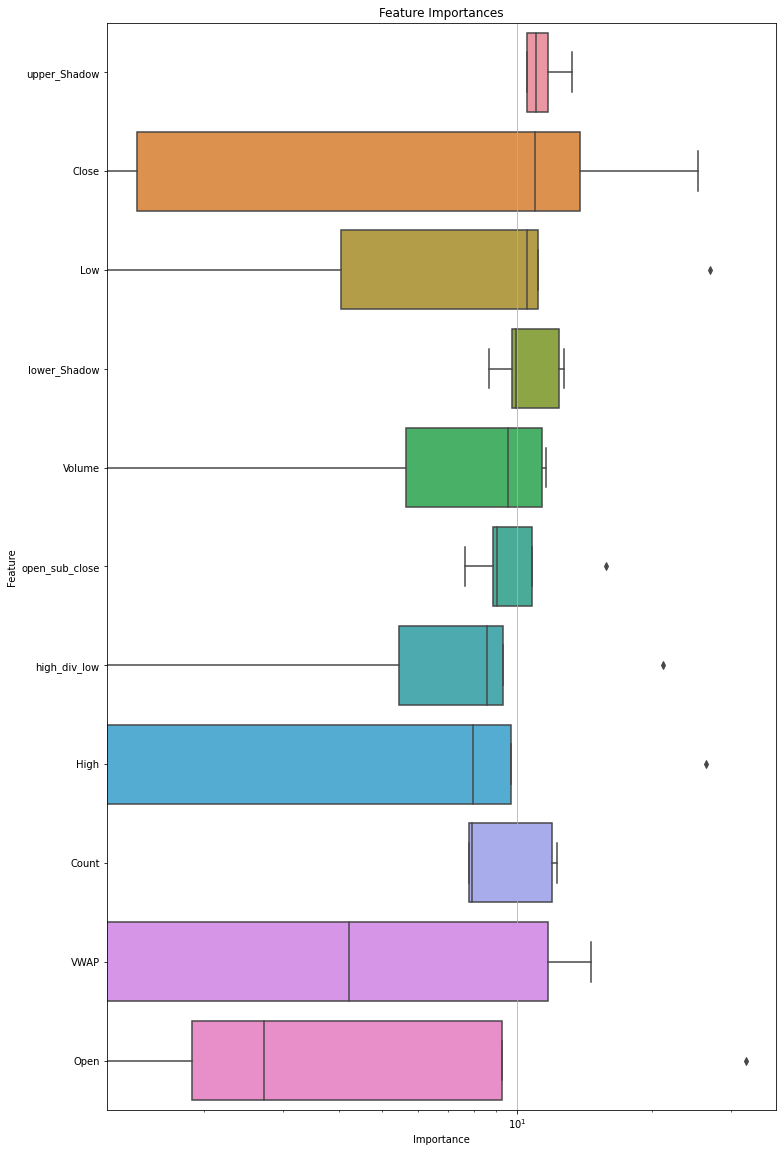

Training model for DOGE   (ID=4 )
#########################
#### FOLD 1
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 1 OOF MSE 0.000 | WCORR: 0.016
#########################
#### FOLD 2
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 2 OOF MSE 0.000 | WCORR: 0.057
#########################
#### FOLD 3
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 3 OOF MSE 0.000 | WCORR: 0.009
#########################
#### FOLD 4
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 4 OOF MSE 0.000 | WCORR: -0.013
#########################
#### FOLD 5
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 5 OOF MSE 0.000 | WCORR: -0.004


--------------------------------------------------------------------------------
Finished training Dogecoin. Results:
Model: r2_score: -0.0028381697446575593 | pearsonr: 0.0020078652591362526 | wcorr: 0.0020078652776018666 
Pre

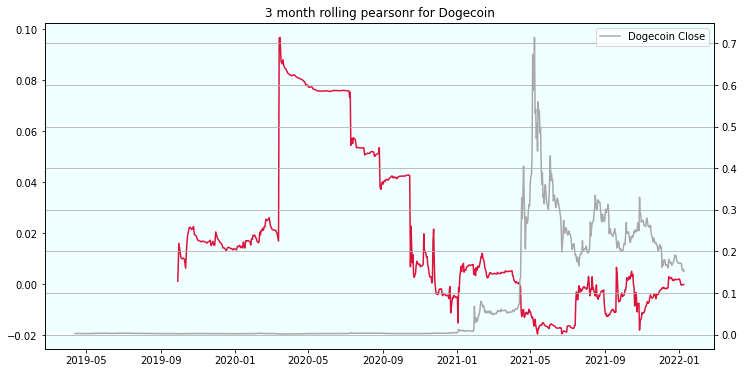

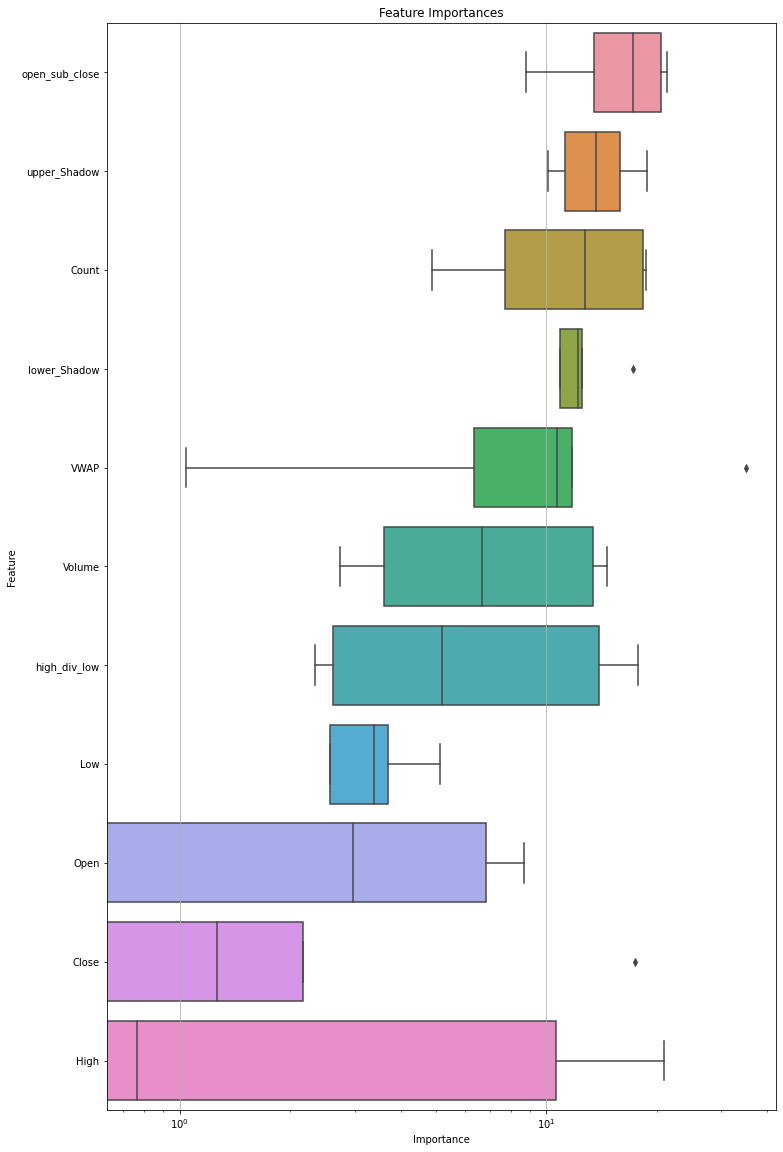

Training model for EOS    (ID=5 )
#########################
#### FOLD 1
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 1 OOF MSE 0.000 | WCORR: 0.045
#########################
#### FOLD 2
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 2 OOF MSE 0.000 | WCORR: 0.025
#########################
#### FOLD 3
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 3 OOF MSE 0.000 | WCORR: 0.014
#########################
#### FOLD 4
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 4 OOF MSE 0.000 | WCORR: 0.003
#########################
#### FOLD 5
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 5 OOF MSE 0.000 | WCORR: -0.001


--------------------------------------------------------------------------------
Finished training EOS.IO. Results:
Model: r2_score: 8.373474468614805e-05 | pearsonr: 0.009307164633346503 | wcorr: 0.00930716475137449 
Prediction

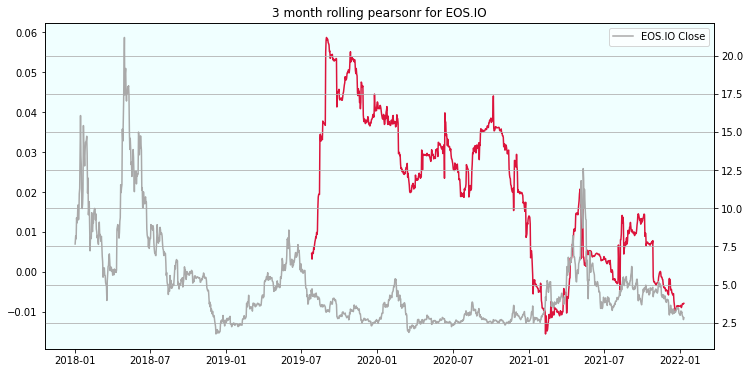

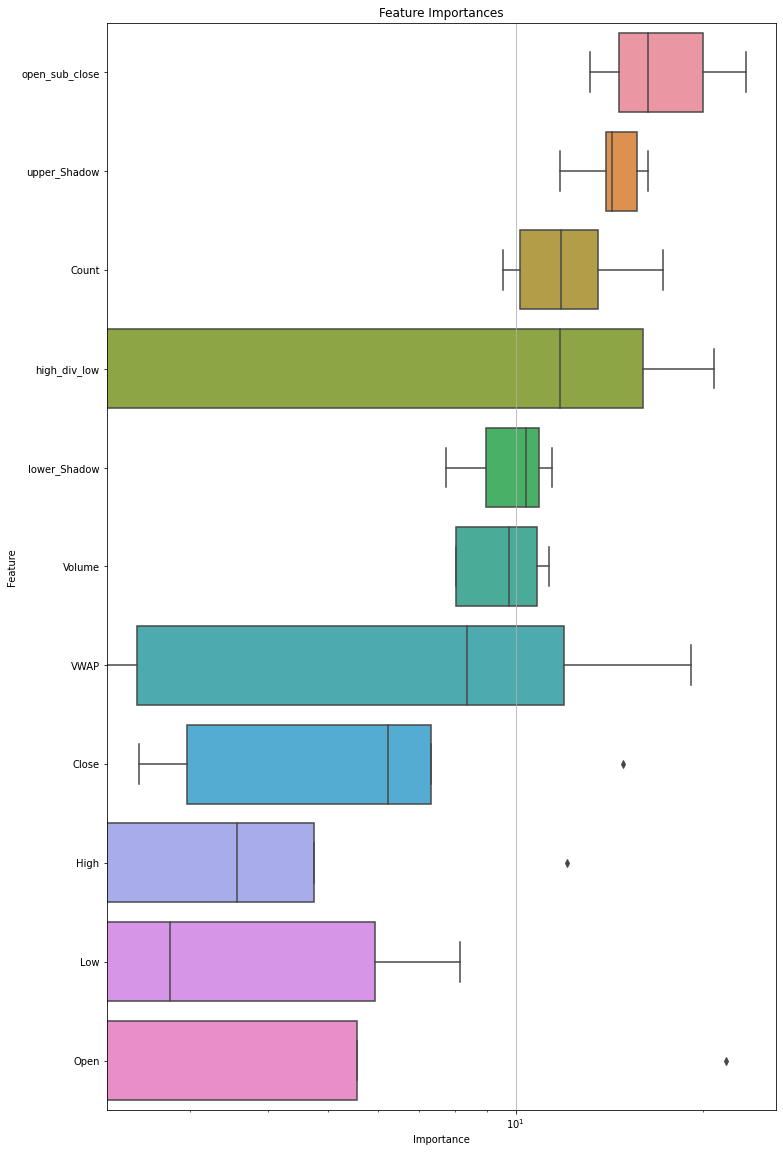

Training model for ETH    (ID=6 )
#########################
#### FOLD 1
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 1 OOF MSE 0.000 | WCORR: 0.052
#########################
#### FOLD 2
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 2 OOF MSE 0.000 | WCORR: 0.056
#########################
#### FOLD 3
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 3 OOF MSE 0.000 | WCORR: 0.002
#########################
#### FOLD 4
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 4 OOF MSE 0.000 | WCORR: 0.007
#########################
#### FOLD 5
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 5 OOF MSE 0.000 | WCORR: 0.002


--------------------------------------------------------------------------------
Finished training Ethereum. Results:
Model: r2_score: 0.00014409055625264067 | pearsonr: 0.014728602894835952 | wcorr: 0.014728602500587249 
Predict

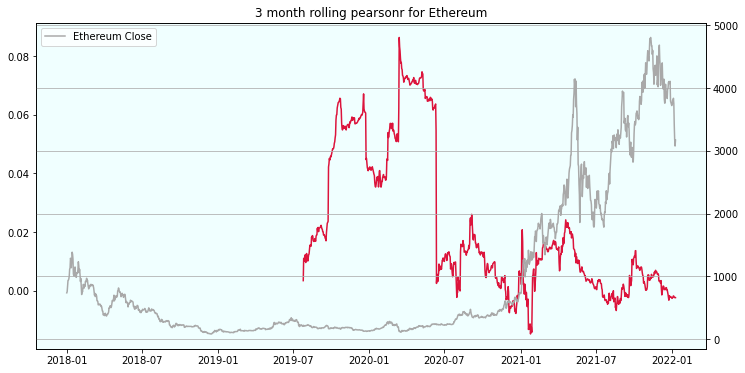

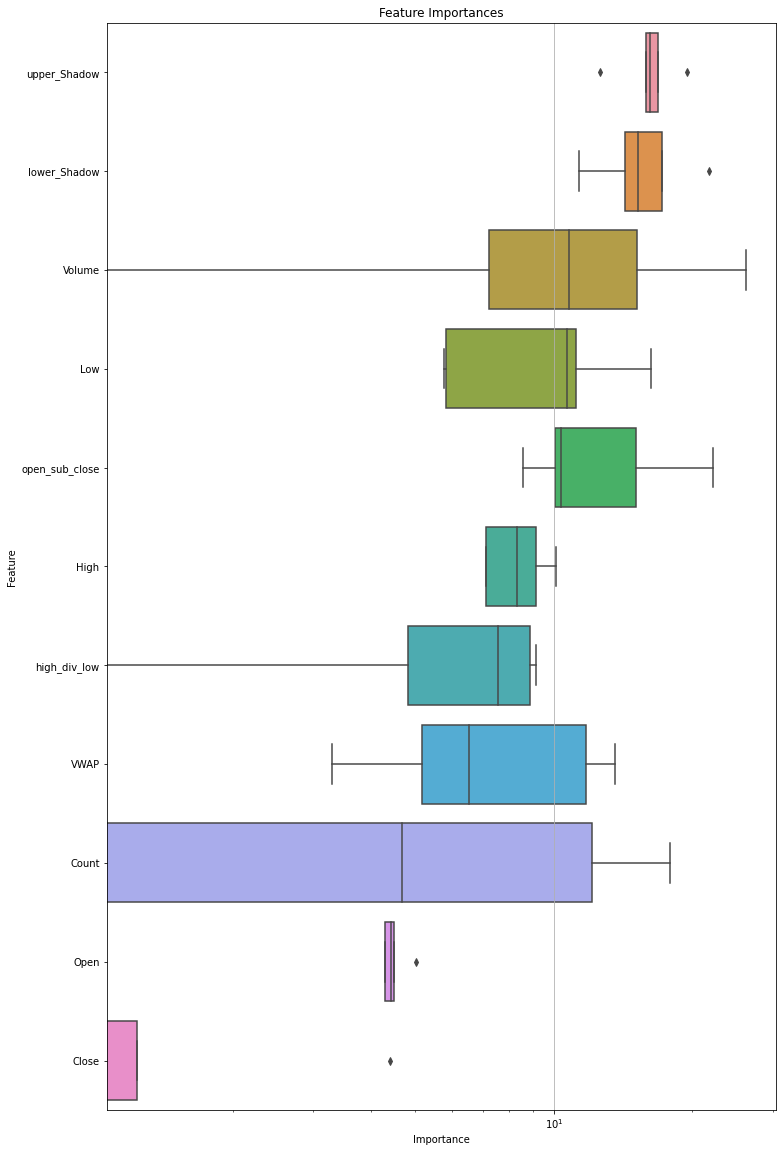

Training model for ETC    (ID=7 )
#########################
#### FOLD 1
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 1 OOF MSE 0.000 | WCORR: -0.008
#########################
#### FOLD 2
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 2 OOF MSE 0.000 | WCORR: 0.001
#########################
#### FOLD 3
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 3 OOF MSE 0.000 | WCORR: 0.006
#########################
#### FOLD 4
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 4 OOF MSE 0.000 | WCORR: -0.009
#########################
#### FOLD 5
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 5 OOF MSE 0.000 | WCORR: 0.010


--------------------------------------------------------------------------------
Finished training Ethereum Classic. Results:
Model: r2_score: -0.00016959518356518544 | pearsonr: 0.00211000043038194 | wcorr: 0.00210999988506442

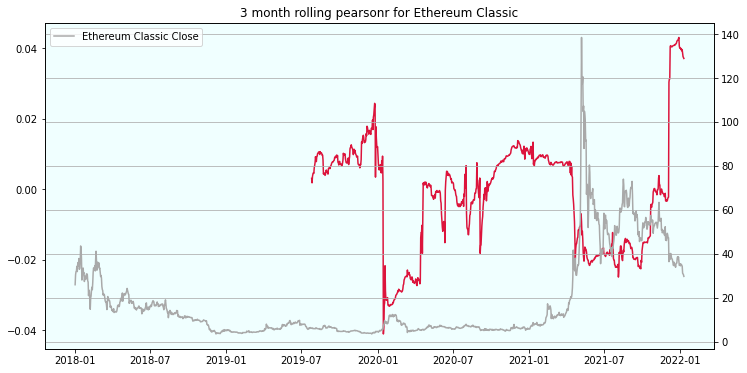

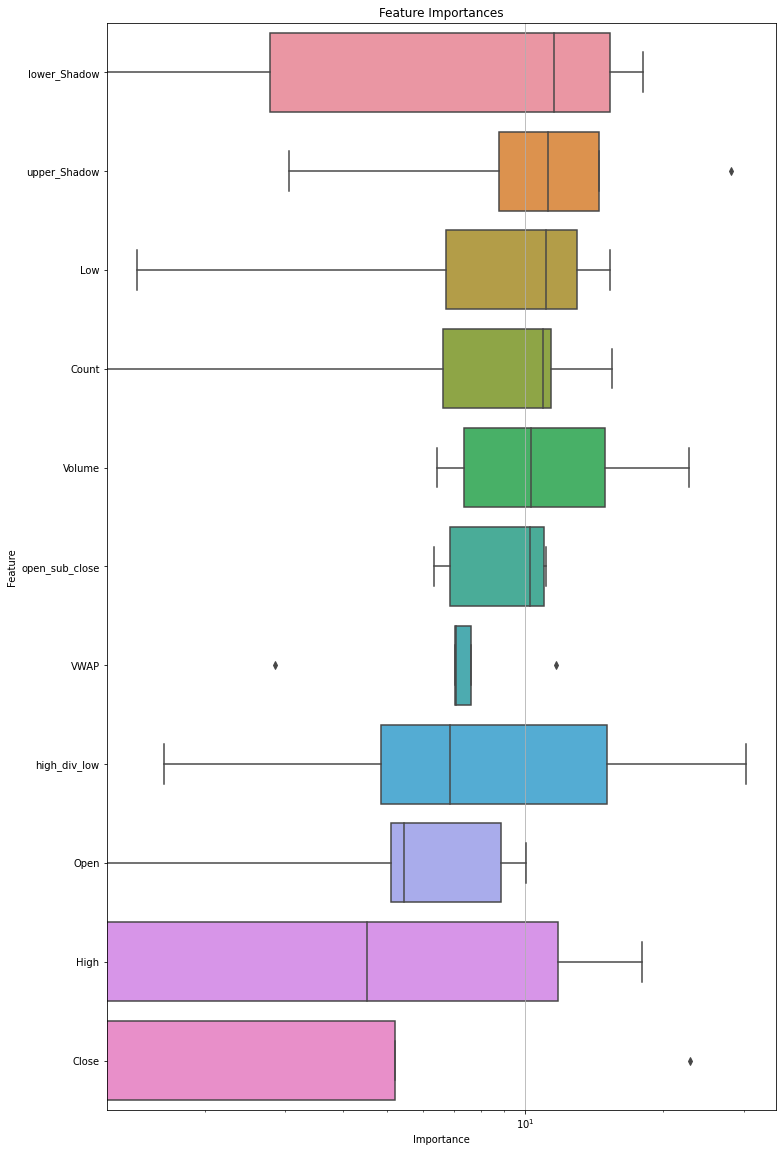

Training model for MIOTA  (ID=8 )
#########################
#### FOLD 1
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 1 OOF MSE 0.000 | WCORR: 0.015
#########################
#### FOLD 2
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 2 OOF MSE 0.000 | WCORR: 0.055
#########################
#### FOLD 3
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 3 OOF MSE 0.000 | WCORR: 0.036
#########################
#### FOLD 4
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 4 OOF MSE 0.000 | WCORR: 0.006
#########################
#### FOLD 5
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 5 OOF MSE 0.000 | WCORR: 0.004


--------------------------------------------------------------------------------
Finished training IOTA. Results:
Model: r2_score: 6.520345675986583e-05 | pearsonr: 0.01185443501516242 | wcorr: 0.01185443492868347 
Predictions st

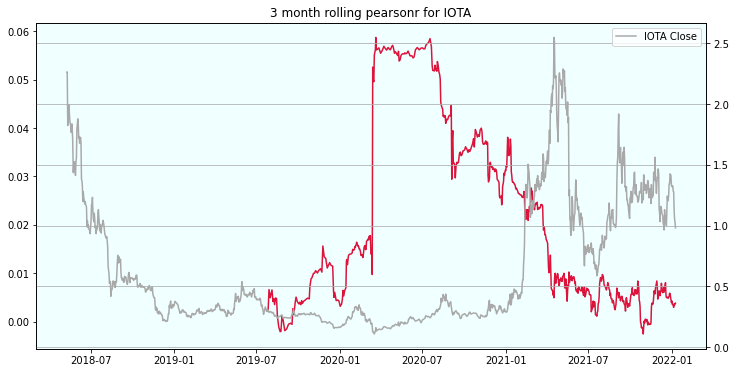

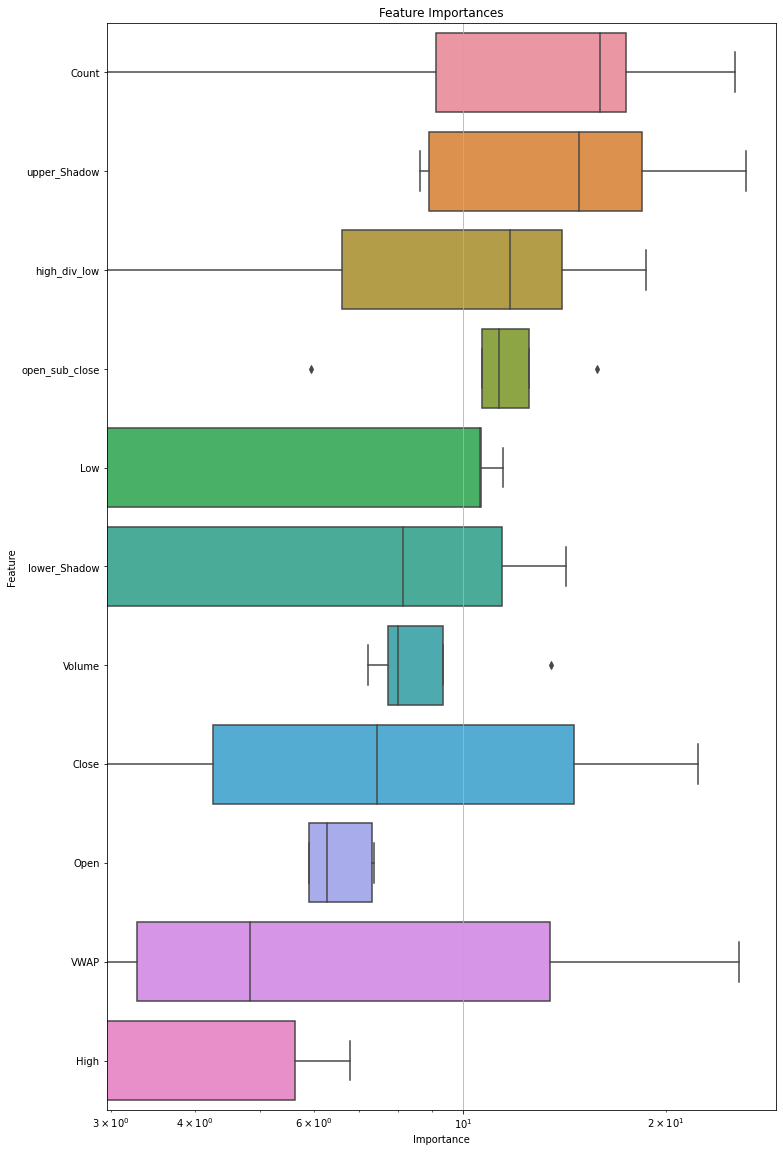

Training model for LTC    (ID=9 )
#########################
#### FOLD 1
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 1 OOF MSE 0.000 | WCORR: 0.004
#########################
#### FOLD 2
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 2 OOF MSE 0.000 | WCORR: 0.032
#########################
#### FOLD 3
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 3 OOF MSE 0.000 | WCORR: 0.037
#########################
#### FOLD 4
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 4 OOF MSE 0.000 | WCORR: 0.006
#########################
#### FOLD 5
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 5 OOF MSE 0.000 | WCORR: 0.032


--------------------------------------------------------------------------------
Finished training Litecoin. Results:
Model: r2_score: 6.502384057083255e-06 | pearsonr: 0.013165291038609195 | wcorr: 0.013165290988815316 
Predicti

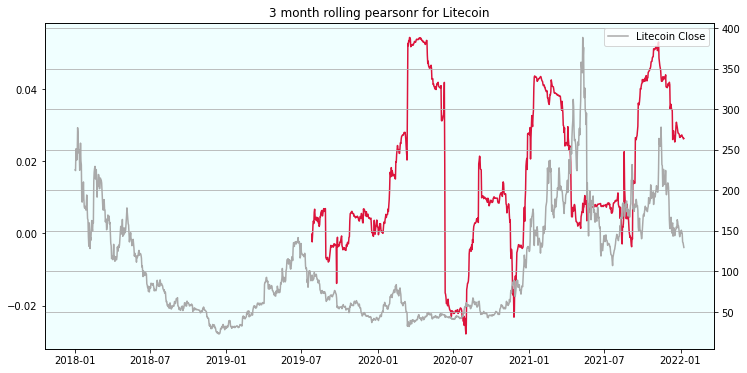

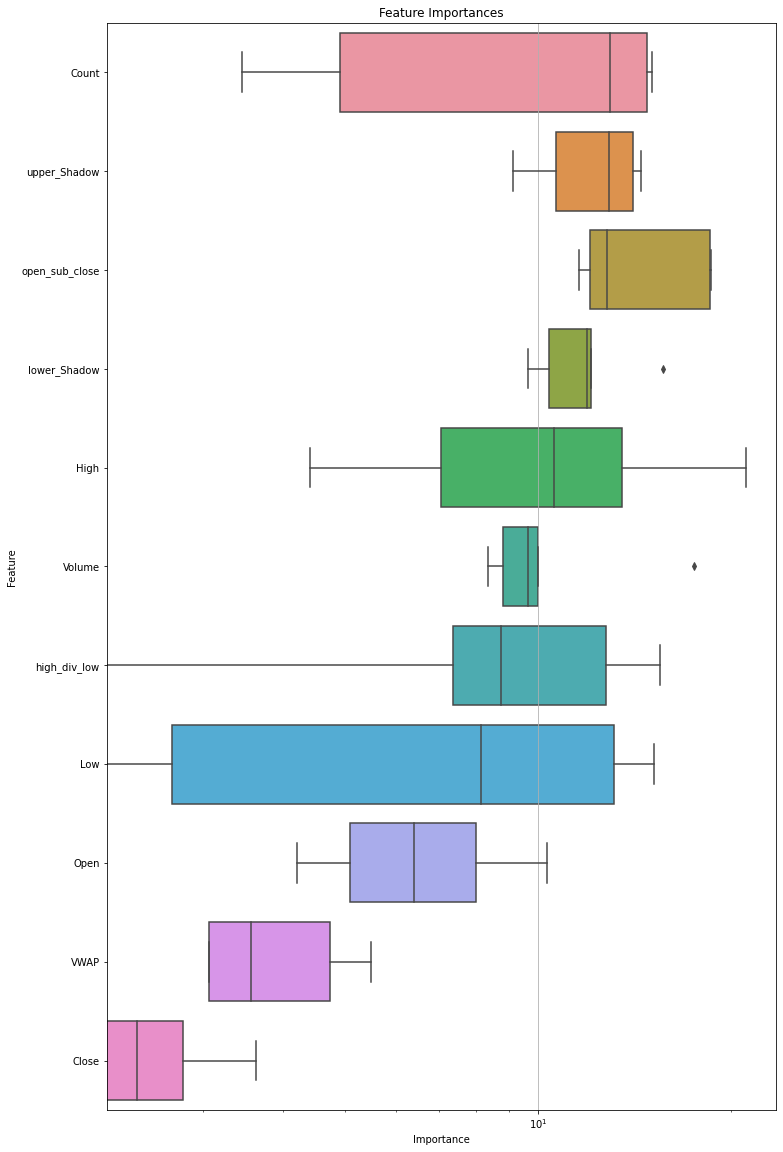

Training model for MKR    (ID=10)
#########################
#### FOLD 1
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 1 OOF MSE 0.000 | WCORR: 0.397
#########################
#### FOLD 2
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 2 OOF MSE 0.000 | WCORR: -0.022
#########################
#### FOLD 3
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 3 OOF MSE 0.000 | WCORR: -0.006
#########################
#### FOLD 4
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 4 OOF MSE 0.000 | WCORR: -0.001
#########################
#### FOLD 5
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 5 OOF MSE 0.000 | WCORR: -0.004


--------------------------------------------------------------------------------
Finished training Maker. Results:
Model: r2_score: 0.009364312312221457 | pearsonr: 0.09820892114154404 | wcorr: 0.09820892077647295 
Prediction

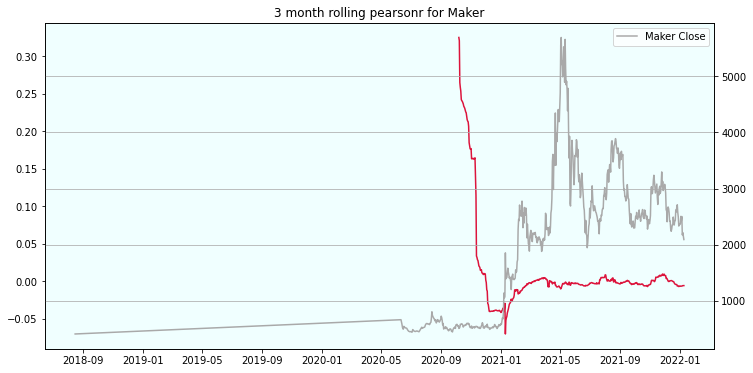

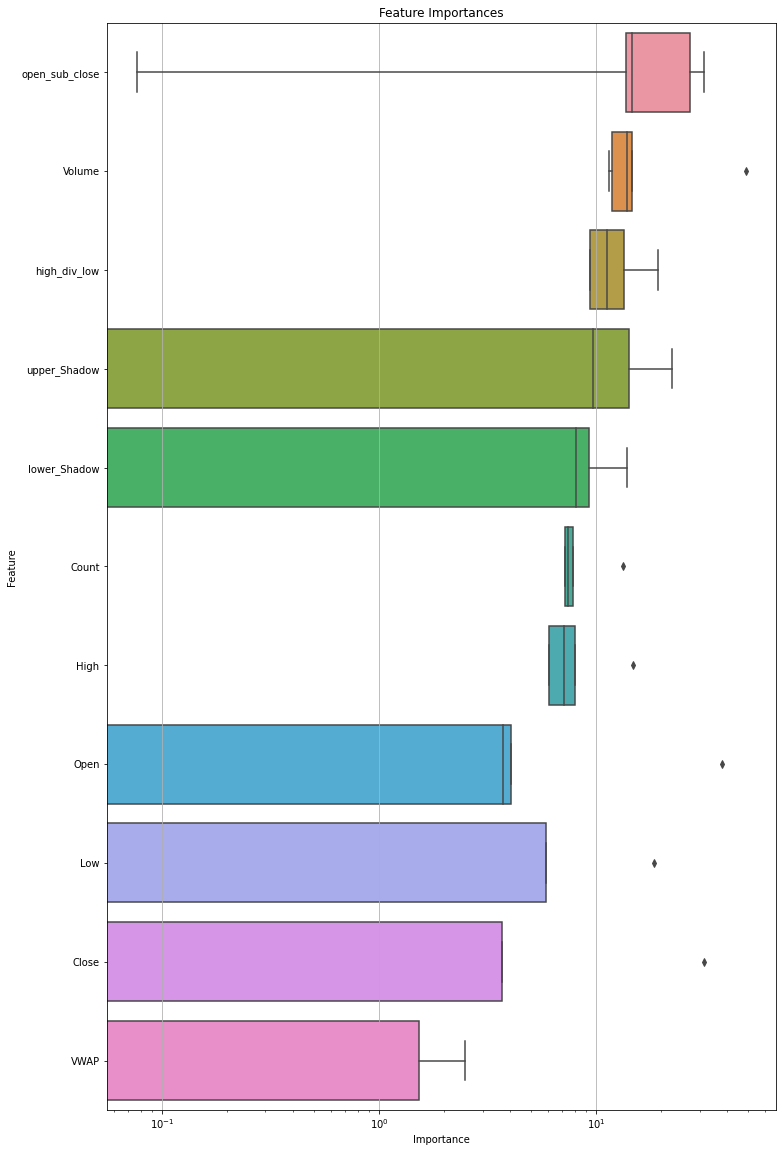

Training model for XMR    (ID=11)
#########################
#### FOLD 1
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 1 OOF MSE 0.000 | WCORR: -0.000
#########################
#### FOLD 2
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 2 OOF MSE 0.000 | WCORR: 0.018
#########################
#### FOLD 3
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 3 OOF MSE 0.000 | WCORR: 0.008
#########################
#### FOLD 4
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 4 OOF MSE 0.000 | WCORR: -0.004
#########################
#### FOLD 5
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 5 OOF MSE 0.000 | WCORR: -0.006


--------------------------------------------------------------------------------
Finished training Monero. Results:
Model: r2_score: -9.282039620095439e-05 | pearsonr: 0.0011027509813348524 | wcorr: 0.0011027512326745054 
Pred

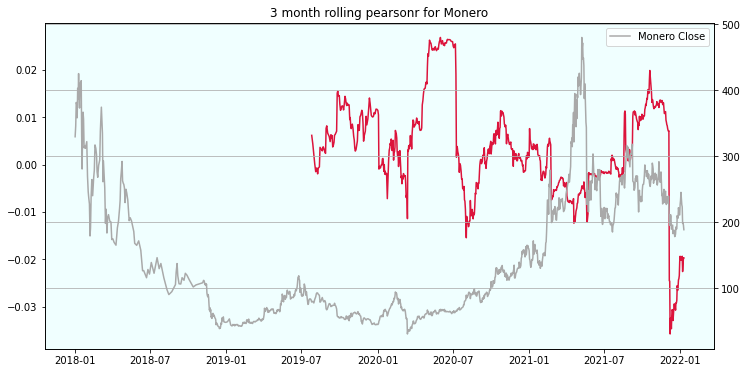

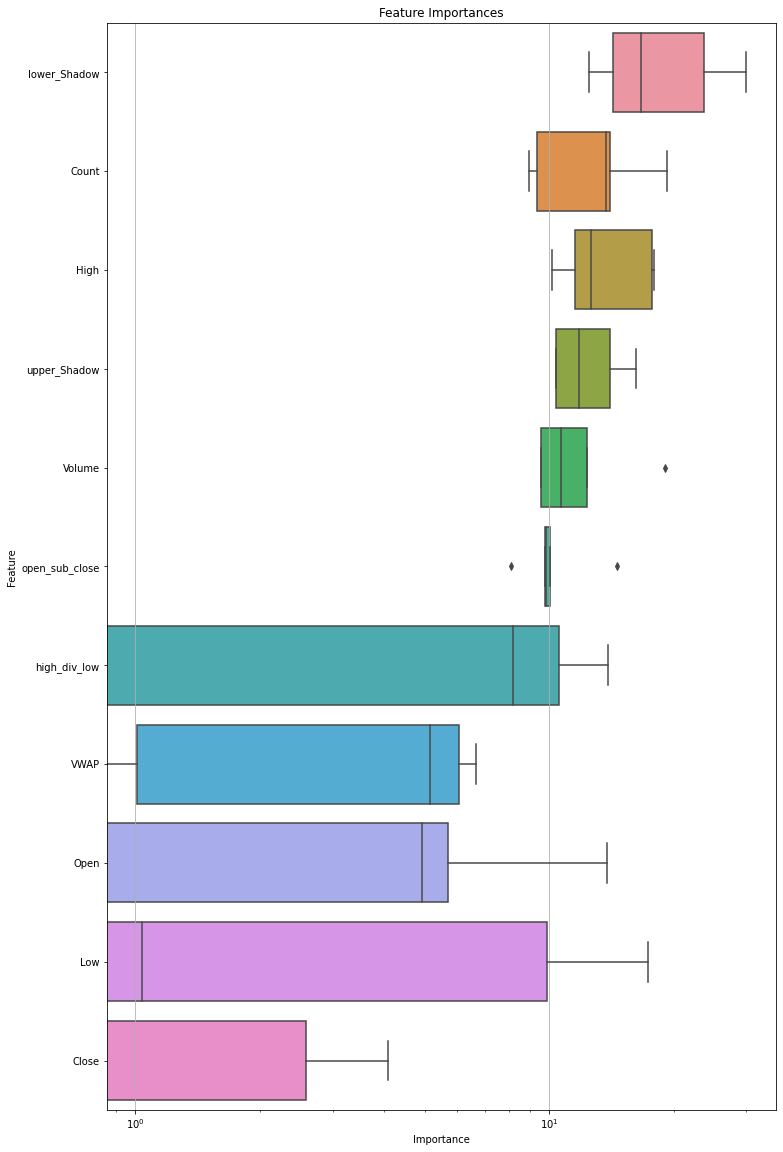

Training model for XLM    (ID=12)
#########################
#### FOLD 1
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 1 OOF MSE 0.000 | WCORR: 0.030
#########################
#### FOLD 2
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 2 OOF MSE 0.000 | WCORR: -0.002
#########################
#### FOLD 3
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 3 OOF MSE 0.000 | WCORR: -0.037
#########################
#### FOLD 4
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 4 OOF MSE 0.000 | WCORR: -0.009
#########################
#### FOLD 5
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 5 OOF MSE 0.000 | WCORR: 0.010


--------------------------------------------------------------------------------
Finished training Stellar. Results:
Model: r2_score: -0.0003677723677824041 | pearsonr: -0.0021095622706131262 | wcorr: -0.0021095619407564886 
P

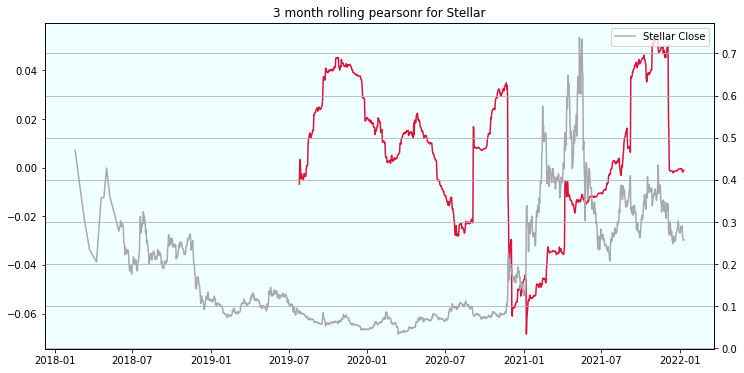

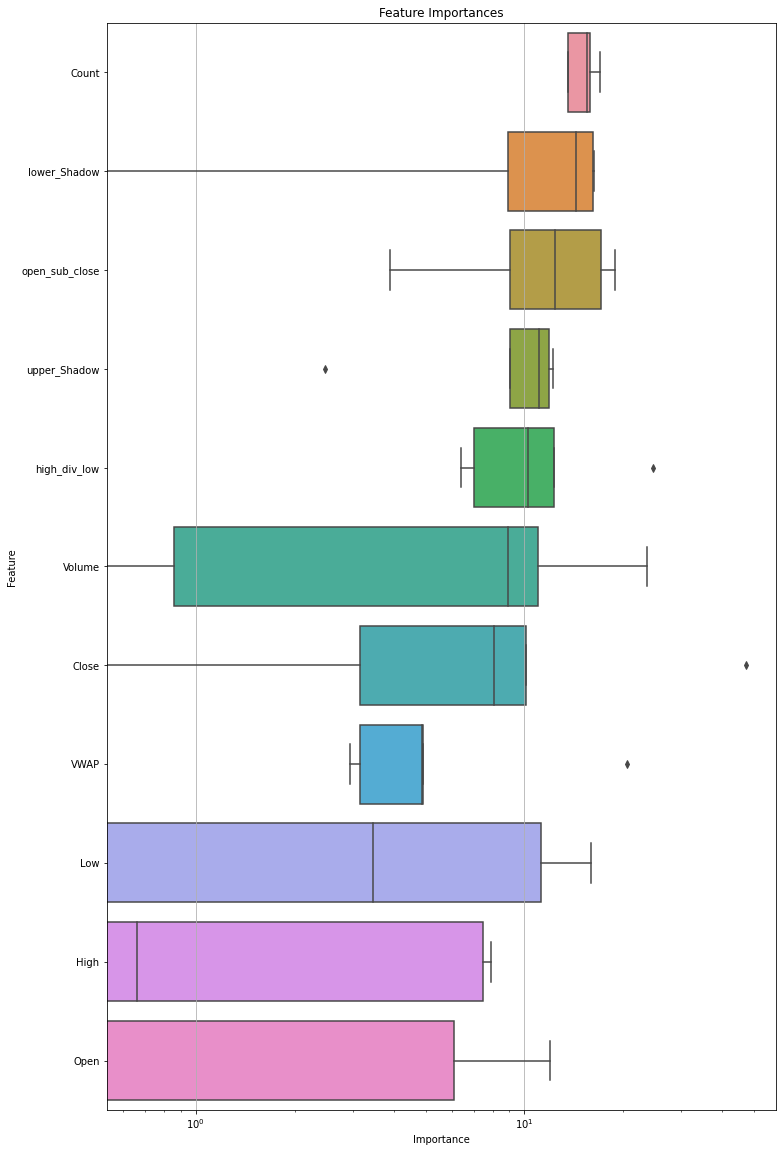

Training model for TRX    (ID=13)
#########################
#### FOLD 1
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 1 OOF MSE 0.000 | WCORR: 0.011
#########################
#### FOLD 2
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 2 OOF MSE 0.000 | WCORR: -0.017
#########################
#### FOLD 3
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 3 OOF MSE 0.000 | WCORR: 0.012
#########################
#### FOLD 4
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 4 OOF MSE 0.000 | WCORR: 0.001
#########################
#### FOLD 5
#### Training N_ESTIMATORS 1000 | MAX_DEPTH 10 | LEARNING_RATE 0.09
#### FOLD 5 OOF MSE 0.000 | WCORR: 0.026


--------------------------------------------------------------------------------
Finished training TRON. Results:
Model: r2_score: -0.0002220005407653769 | pearsonr: 0.003920352459402172 | wcorr: 0.003920351478939008 
Prediction

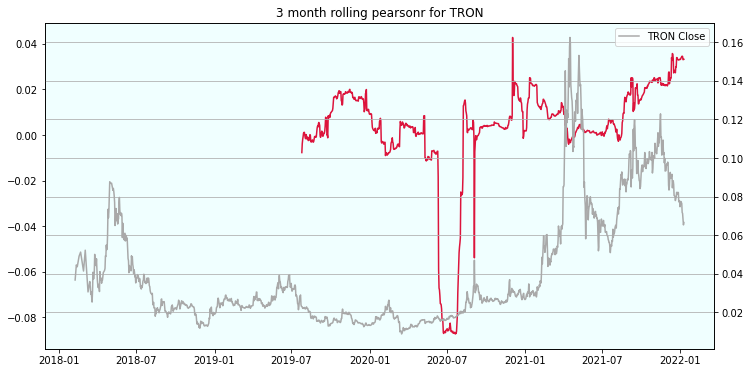

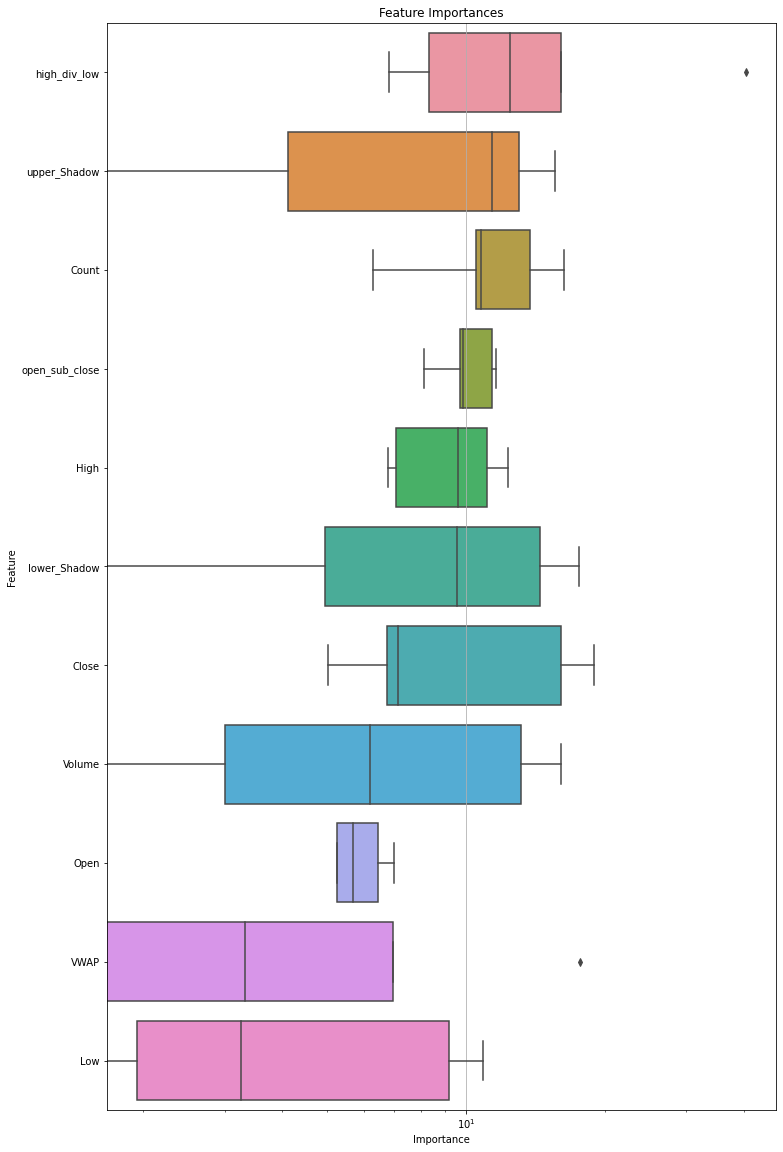

In [27]:
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE = 0

# Train per asset, so I need to use hourly df of each asset
def get_Xy_and_model_for_asset(asset_id, symbol):
#     df = load_training_data_for_asset(asset_id) # No need because my data is separate
    df = minutes[symbol]   # modified to work with the hourly dataframe by asset
    orig_close = df['Close'].copy()
    df_proc = get_features(df)
    df_proc['date'] = df['date'].copy()
    df_proc['y'] = df['Target']
    df_proc = df_proc.dropna(how="any")
    X = df_proc.drop("y", axis=1)
    y = df_proc["y"]
    groups = pd.factorize(X['date'].dt.day.astype(str) + '_' + X['date'].dt.month.astype(str) + '_' + X['date'].dt.year.astype(str))[0]
    X = X.drop(columns = 'date')
    oof_preds = np.zeros(len(X))
    importances, scores, models = [], [], []
    for fold, (train_idx, val_idx) in enumerate(PurgedGroupTimeSeriesSplit(n_splits = FOLDS, group_gap = GROUP_GAP, max_train_group_size = MAX_TRAIN_GROUP_SIZE, max_test_group_size = MAX_TEST_GROUP_SIZE).split(X, y, groups)):
        # GET TRAINING, VALIDATION SET
        x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # DISPLAY FOLD INFO
        print('#' * 25); print('#### FOLD', fold + 1)
        print('#### Training N_ESTIMATORS %s | MAX_DEPTH %s | LEARNING_RATE %s' % (N_ESTIMATORS[fold], MAX_DEPTH[fold], LEARNING_RATE[fold]))

        model = build_model(fold, weight = np.array([asset_weight_dict[asset_id]] * len(y_val)))

        # TRAIN
        model.fit( x_train, y_train, eval_set = [(x_val, y_val)], early_stopping_rounds = 50, verbose = VERBOSE)

        # PREDICT OOF
        pred = model.predict(x_val)
        models.append(model)       
        
        # REPORT RESULTS
        try: mse = mean_squared_error(np.nan_to_num(y_val), np.nan_to_num(pred))
        except: mse = 0.0

        scores.append(mse)
        oof_preds[val_idx] = pred
        importances.append(model.get_feature_importance())
        
        w_score = corr(np.nan_to_num(y_val), np.nan_to_num(pred.flatten()), np.array([asset_weight_dict[asset_id]] * len(y_val)))
        print('#### FOLD %i OOF MSE %.3f | WCORR: %.3f' % (fold + 1, mse, w_score))
        
    df = df_proc
    df['oof_preds'] = np.nan_to_num(oof_preds)
    df['Close'] = orig_close
    print('\n\n' + ('-' * 80) + '\n' + 'Finished training %s. Results:' % asset_name_dict[asset_id])
    print('Model: r2_score: %s | pearsonr: %s | wcorr: %s ' % (r2_score(df['y'], df['oof_preds']), pearsonr(df['y'], df['oof_preds'])[0], corr(df['y'].values, df['oof_preds'].values, np.array([asset_weight_dict[asset_id]] * len(df['y'].values)))))
    print('Predictions std: %s | Target std: %s' % (df['oof_preds'].std(), df['y'].std()))
    try: plt.close()
    except: pass   
    df2 = df.reset_index(drop = True).set_index('date')
    fig = plt.figure(figsize = (12, 6))
    # fig, ax_left = plt.subplots(figsize = (12, 6))
    ax_left = fig.add_subplot(111)
    ax_left.set_facecolor('azure')    
    ax_right = ax_left.twinx()
    ax_left.plot(df2['y'].rolling(3 * 30 * 24 * 60).corr(df2['oof_preds']).iloc[::24 * 60], color = 'crimson', label = "Target WCorr")
    ax_right.plot(df2['Close'].iloc[::24 * 60], color = 'darkgrey', label = "%s Close" % asset_name_dict[asset_id])   
    plt.legend()
    plt.grid()
    plt.xlabel('Time')
    plt.title('3 month rolling pearsonr for %s' % (asset_name_dict[asset_id]))
    plt.show()
    
    plot_importance(np.array(importances), list(X.columns), PLOT_TOP_N = 20)
    
    return scores, oof_preds, models, y

models, scores, targets, oof_preds = {}, {}, {}, {}

# Traing all assets at once, modified to work with my hourly df for each model
for asset_id, symbol in zip(asset_details['Asset_ID'], asset_details['Symbol']):
    print(f"Training model for {symbol:<6} (ID={asset_id:<2})")
    cur_scores, cur_oof_preds, cur_models, cur_targets = get_Xy_and_model_for_asset(asset_id, symbol)
    scores[asset_id], oof_preds[asset_id], models[asset_id], targets[asset_id] = np.mean(cur_scores), cur_oof_preds, cur_models, cur_targets

# Calculate OOF MSE

In [28]:
# COMPUTE OVERALL OOF MSE
print('Overall MEAN OOF MSE %s' % np.mean(list(scores.values())))

# SAVE OOF TO DISK 
y_pred, y_true, weights = [], [], []
for asset in oof_preds:
    df_oof = pd.DataFrame(dict(asset_id = asset, oof_preds=oof_preds[asset]))
    df_oof.to_csv(str(asset) + '_oof.csv',index=False)
    y_pred += oof_preds[asset].tolist()
    y_true += targets[asset].tolist() 
    weights += ([asset_weight_dict[asset]] * len(oof_preds[asset].tolist()))
    print('%s score: %s' % (asset_name_dict[asset], corr(np.nan_to_num(np.array(y_true).flatten()), np.nan_to_num(np.array(y_pred).flatten()), np.nan_to_num(np.array(weights).flatten()))))
    
print('Overall score %s' % corr(np.nan_to_num(np.array(y_true).flatten()), np.nan_to_num(np.array(y_pred).flatten()), np.nan_to_num(np.array(weights).flatten())))

Overall MEAN OOF MSE 0.0
Binance Coin score: 0.0005259249059666857
Bitcoin score: 0.0015265501046174278
Bitcoin Cash score: 0.000967536930025309
Cardano score: 0.0039879013587322985
Dogecoin score: 0.002739924428930614
EOS.IO score: 0.002861061034801504
Ethereum score: 0.00346181434307967
Ethereum Classic score: 0.0031654022163804716
IOTA score: 0.003637568826359526
Litecoin score: 0.0039982566573161
Maker score: 0.009665477802102454
Monero score: 0.009342601012364686
Stellar score: 0.008940760566079845
TRON score: 0.008774435623240347
Overall score 0.008774435623240347


# Save the results for submission to Kaggle

In [29]:
all_df_test = []

env = gresearch_crypto.make_env()
iter_test = env.iter_test()

for i, (df_test, df_pred) in enumerate(iter_test):
    for j , row in df_test.iterrows():
        try:
            if row['Asset_ID'] in models:
                cur_models = models[row['Asset_ID']]
                x_test = get_features(row)
                y_pred = np.mean(np.concatenate([np.expand_dims(model.predict([x_test]), axis = 0) for model in cur_models], axis = 0), axis = 0)
            else: y_pred = 0.0
        except: 
            y_pred = 0.0
            traceback.print_exc()
        df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = y_pred
    all_df_test.append(df_test)
    env.predict(df_pred)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [30]:
all_df_test

[     timestamp  Asset_ID  Count          Open          High           Low  \
 0   1623542400         3   1201      1.478556      1.486030      1.478000   
 1   1623542400         2   1020    580.306667    583.890000    579.910000   
 2   1623542400         0    626    343.789500    345.108000    343.640000   
 3   1623542400         1   2888  35554.289632  35652.464650  35502.670000   
 4   1623542400         4    433      0.312167      0.312600      0.311920   
 5   1623542400         5    359      4.832550      4.845900      4.822900   
 6   1623542400         7    541     55.223080     55.494000     55.182000   
 7   1623542400         6   2186   2371.194286   2379.200000   2369.670000   
 8   1623542400         8     35      1.003150      1.019800      0.987300   
 9   1623542400         9    560    161.933429    162.480000    161.730000   
 10  1623542400        10     61   2939.862750   2952.160000   2936.230000   
 11  1623542400        13    229      0.068132      0.068240    